In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [3]:
dir = "/content/drive/MyDrive/SafeReels-664/Extracted_Features"

In [4]:
X = []

In [5]:
for file in os.listdir(dir):
    if file.endswith(".npy"):
        file_path = os.path.join(dir, file)
        features = np.load(file_path)
        X.append(features)

In [6]:
X = np.array(X, dtype=np.float32)

In [7]:
X.shape

(664, 21160)

In [8]:
import pandas as pd
df = pd.read_csv("/content/Safereels annotation - Text_Annotation_data.csv")
df

,reel_id,isSafe,UnsafeType,Visual texts,Audio texts
0,www.facebook.com/reel/1000188341415358,1,Safe,Me on my way to watch Oppenheimer After Berbie,NaN
1,www.facebook.com/reel/1006146964533997,1,Safe,NaN,এ মামা দুইটা সিঙ্গারা আর দুইটা সমুচা একটু তাড়া...
2,www.facebook.com/reel/1007123741459823,0,Adult,বান্ধবী আমার লাগানির পিনিকে আছে Love in love,পাগলা হাওয়ার বাদল দিনে পাগল আমার মন জেগে ওঠে প...
3,www.facebook.com/reel/1007420607202244,1,Safe,প্রত্যেকটা অফিসে এমন একজন কলিগ থাকবেই Laptop,যুদ্ধ আনে ধ্বংস সজনী সজনী তোমারে দেখিয়া মাতাল ...
4,www.facebook.com/reel/1008519870870927,1,Safe,হ্যালো শার্ক ট্যাঙ্ক বাংলাদেশ আই এম কামিং,NaN
...,...,...,...,...,...
659,www.facebook.com/reel/997262608752854,0,Adult,NaN,NaN
660,www.facebook.com/reel/997300345735398,0,Harmful,NaN,NaN
661,www.facebook.com/reel/998187401354206,1,Safe,খবরঃ কয়লা নিয়ে মোংলা বন্দরে এলো চীনের জাহাজ দে...,NaN
662,www.facebook.com/reel/999558344609179,1,Safe,সাকিব আল হাসান to বাংলাদেশী ক্রিকেট ফ্যান,NaN


In [9]:
df['UnsafeType'], uniques = pd.factorize(df['UnsafeType'])
uniques

Index(['Safe', 'Adult', 'Harmful', 'Suicidal'], dtype='object')

In [10]:
y = df['UnsafeType'].tolist()

In [11]:
y = np.array(y)
y.shape

(664,)

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [13]:
X = np.expand_dims(X, axis=-1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(4, activation='softmax')  # 4-class output
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 287ms/step - accuracy: 0.4456 - loss: 54.9324 - val_accuracy: 0.2556 - val_loss: 15.9816
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.5552 - loss: 34.3294 - val_accuracy: 0.1654 - val_loss: 31.2909
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.5683 - loss: 21.9150 - val_accuracy: 0.1955 - val_loss: 38.5062
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.5575 - loss: 23.4499 - val_accuracy: 0.2256 - val_loss: 26.1850
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5551 - loss: 9.4624 - val_accuracy: 0.1128 - val_loss: 81.0581
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.6373 - loss: 9.4680 - val_accuracy: 0.1504 - val_loss: 56.2321
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.6409 - loss: 8.2729 - val_accuracy: 0.1053 - val_loss: 68.7204
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.6554 - loss: 2.5914 - val_accurac

In [18]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6662 - loss: 1.7922
Test Accuracy: 0.6391


In [19]:
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


In [21]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.63      1.00      0.78        83
           1       1.00      0.03      0.05        36
           2       1.00      0.08      0.14        13
           3       0.00      0.00      0.00         1

    accuracy                           0.64       133
   macro avg       0.66      0.28      0.24       133
weighted avg       0.76      0.64      0.51       133



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

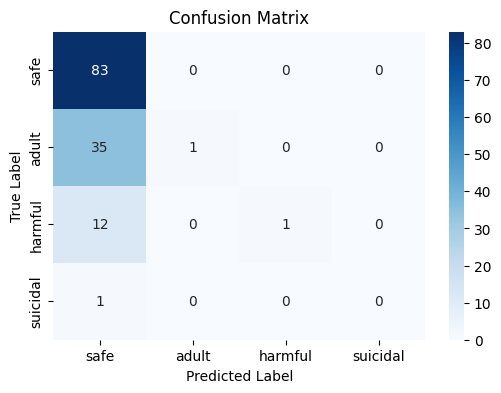

In [28]:
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["safe","adult","harmful","suicidal"], yticklabels=["safe","adult","harmful","suicidal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()